# Customer Behavior Prediction using Deep Learning

Author: Tatsiana Mihai

## Project description

For this project I'll use public datasets with user behavior information available on Kaggle:
- Model training: E-commerce behavior data from multi category store for November 2019
https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store
- Validating model robustness: E-commerce behavior data from multi category store for January 2020 https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store


## Data exploration

In [1]:
# import required packages

import pandas as pd
import numpy as np

Disclaimer: due to Github size constraints `data` folder is not provided in this repository. You can download source files by using links mentioned in the Project Description

In [3]:
# read csv file and get the number of rows

# training dataset
df = pd.read_csv('data/2019-Nov.csv')

# testing dataset
#df = pd.read_csv('data/2020-Jan.csv')

df.count()

event_time       67501979
event_type       67501979
product_id       67501979
category_id      67501979
category_code    45603808
brand            58277901
price            67501979
user_id          67501979
user_session     67501969
dtype: int64

In [4]:
# show the first rows in the dataframe
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


Let's check the quality of the data. Firts, I want to make sure there're no rows with null or invalid values that might affect model training. 
Let's check which columns have null values and how many.

In [5]:
# show sum of null values for each column

df.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    21898171
brand             9224078
price                   0
user_id                 0
user_session           10
dtype: int64

As we can see, there're quite many missed values for `category_code` and `brand`, and also 10 missed values for the `user_session`. 
Now let's check if there're negative `price` values for as they're invalid and will affect the accuracy of the trained model.

In [6]:
# show sum of negative values for the column `price`

(df.price < 0).sum()

0

As we can see, all prices are greater than `0` which makes the dataset is pretty clean. The only issue I'd like to address is the missed values. Also, I'd like to transform composite values in the `category_column` into multi-dimentional features to later try different combinations for model training.

## Data preprocessing

**Reduce dimensionality**  
The dataset is large, however not all of the columns are signficant for model training. The `user_session` column can be dropped as the `user_id` colimn contains all necessary information without missed values. Therefore, I'll remove `user_id` from the dataset.

In [7]:
# keep only necessary columns
required_cols = [
    'event_time',
    'event_type',
    'category_code',
    'product_id',
    'category_id',
    'brand',
    'price',
    'user_id'
]

df = df[required_cols]
df.head()

,event_time,event_type,category_code,product_id,category_id,brand,price,user_id
0,2019-11-01 00:00:00 UTC,view,electronics.smartphone,1003461,2053013555631882655,xiaomi,489.07,520088904
1,2019-11-01 00:00:00 UTC,view,appliances.sewing_machine,5000088,2053013566100866035,janome,293.65,530496790
2,2019-11-01 00:00:01 UTC,view,NaN,17302664,2053013553853497655,creed,28.31,561587266
3,2019-11-01 00:00:01 UTC,view,appliances.kitchen.washer,3601530,2053013563810775923,lg,712.87,518085591
4,2019-11-01 00:00:01 UTC,view,electronics.smartphone,1004775,2053013555631882655,xiaomi,183.27,558856683


**Handling the missing values**

As we can see from the data exploration, there're 9224078 missed values in the `brand` column. As there's still other information such as `event_type`, `user_id` and `price`, which can be useful for ML training, I'll fill it with the value `unknown`. 
Apart fron that, some of `category_code` values contain `NaN` instead of expected string values which causes issues with data transformation. I'll fill them with `unknown` values as well.

In [8]:
df['brand'] = df['brand'].fillna('unknown')
df['category_code'] = df['category_code'].fillna('unknown')
df.head()

,event_time,event_type,category_code,product_id,category_id,brand,price,user_id
0,2019-11-01 00:00:00 UTC,view,electronics.smartphone,1003461,2053013555631882655,xiaomi,489.07,520088904
1,2019-11-01 00:00:00 UTC,view,appliances.sewing_machine,5000088,2053013566100866035,janome,293.65,530496790
2,2019-11-01 00:00:01 UTC,view,unknown,17302664,2053013553853497655,creed,28.31,561587266
3,2019-11-01 00:00:01 UTC,view,appliances.kitchen.washer,3601530,2053013563810775923,lg,712.87,518085591
4,2019-11-01 00:00:01 UTC,view,electronics.smartphone,1004775,2053013555631882655,xiaomi,183.27,558856683


Let's see how many categories we can restore by mapping their known brands. To do that, I'll get a list of unique combinations of unknown category codes and known brands. 

In [9]:
# extract uniquecvalues from `category_code` and `brand` columns

unknown_cats = df[(df.category_code == 'unknown') & (df.brand != 'unknown')]
unknown_cats = pd.unique(unknown_cats['brand'])

len(unknown_cats)

3036

Now let's explore if it's possible to re-use category that defined for another product with the same `brand` value. To do that I'll fetch all categories from `category_code` for the brands listed in the `unknown_cats`

<Axes: xlabel='category_code'>

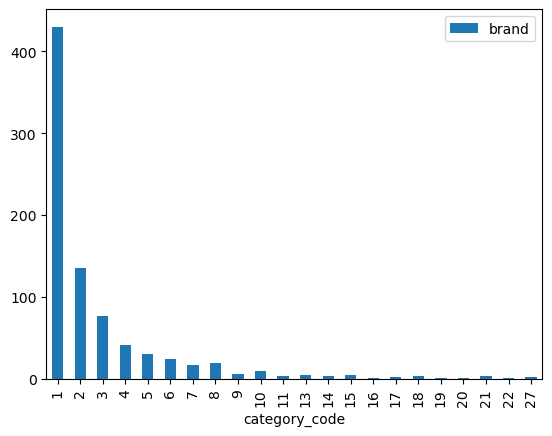

In [10]:
# try to find categories for the brands

known_brands = df[(df.category_code != 'unknown') & (df.brand.isin(unknown_cats))]
known_brands = known_brands[['category_code', 'brand']]
brands_possible_cats = known_brands.groupby(by=['brand']).nunique().reset_index()

# group brands to see how many potential categories each brand has
grouped_known_brands = brands_possible_cats.groupby(by=['category_code']).count()
grouped_known_brands.plot(kind='bar')

As the plot shows, a big chunk of brands has just one possible category. Let's explore some of them

In [11]:
brands_with_single_cat = brands_possible_cats[\
        brands_possible_cats.category_code == 1].brand

known_brands[known_brands.brand.isin(brands_with_single_cat)][210:220]

,category_code,brand
14038,apparel.underwear,milavitsa
14061,apparel.underwear,milavitsa
14092,electronics.audio.subwoofer,element
14105,appliances.environment.vacuum,dyson
14130,apparel.underwear,milavitsa
14139,appliances.sewing_machine,brother
14143,appliances.sewing_machine,janome
14147,appliances.environment.water_heater,ariston
14168,electronics.audio.subwoofer,element
14256,apparel.underwear,milavitsa


In [12]:
brands_with_multi_cat = brands_possible_cats[\
        brands_possible_cats.category_code > 25].brand

known_brands[known_brands.brand.isin(brands_with_multi_cat)].head()

,category_code,brand
0,electronics.smartphone,xiaomi
4,electronics.smartphone,xiaomi
44,appliances.kitchen.dishwasher,bosch
49,electronics.smartphone,xiaomi
69,electronics.smartphone,xiaomi


In [13]:
known_brands[known_brands.brand == 'xiaomi'].head(20)

,category_code,brand
0,electronics.smartphone,xiaomi
4,electronics.smartphone,xiaomi
49,electronics.smartphone,xiaomi
69,electronics.smartphone,xiaomi
82,electronics.audio.headphone,xiaomi
95,electronics.smartphone,xiaomi
121,electronics.smartphone,xiaomi
131,electronics.smartphone,xiaomi
153,electronics.audio.headphone,xiaomi
165,electronics.smartphone,xiaomi


At this moment it's obviout that only the first level category makes sence to be copied and added to the rows with missed values. If I add second or third category level I might affect the quality of the data.

**Data transformation**  
First, I want to transform values from `category_code` into multi-column data `cat_1`, `cat_2`, etc.
To make it I need to know the length of the longest chain in the `category_code` column.

In [14]:
# calculate the max number of categories

max(df.category_code.transform(lambda x: x.str.split('.').transform(lambda y: len(y))))

4

**Imputation**
The maximum length of nested categories is `4`. Now it's possible to create new columns to store each category separately. As only the first layer of categories is to be filled for unknown categories, the other empty values can be filled with `unknown`.  

In [15]:
# split `category_code` column into new columns
df[['cat_1', 'cat_2', 'cat_3', 'cat_4']] = df.category_code.str.split(".", expand = True)
df.head()

,event_time,event_type,category_code,product_id,category_id,brand,price,user_id,cat_1,cat_2,cat_3,cat_4
0,2019-11-01 00:00:00 UTC,view,electronics.smartphone,1003461,2053013555631882655,xiaomi,489.07,520088904,electronics,smartphone,None,None
1,2019-11-01 00:00:00 UTC,view,appliances.sewing_machine,5000088,2053013566100866035,janome,293.65,530496790,appliances,sewing_machine,None,None
2,2019-11-01 00:00:01 UTC,view,unknown,17302664,2053013553853497655,creed,28.31,561587266,unknown,None,None,None
3,2019-11-01 00:00:01 UTC,view,appliances.kitchen.washer,3601530,2053013563810775923,lg,712.87,518085591,appliances,kitchen,washer,None
4,2019-11-01 00:00:01 UTC,view,electronics.smartphone,1004775,2053013555631882655,xiaomi,183.27,558856683,electronics,smartphone,None,None


As the values from the `category_code` column are transferred to another columns, it can be finally removed.

In [16]:
# keep only necessary columns
required_cols = [
    'event_time',
    'event_type',
    'product_id',
    'category_id',
    'cat_1',
    'cat_2',
    'cat_3',
    'cat_4',
    'brand',
    'price',
    'user_id'
]

df = df[required_cols]
df.head()

,event_time,event_type,product_id,category_id,cat_1,cat_2,cat_3,cat_4,brand,price,user_id
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics,smartphone,None,None,xiaomi,489.07,520088904
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances,sewing_machine,None,None,janome,293.65,530496790
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,unknown,None,None,None,creed,28.31,561587266
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances,kitchen,washer,None,lg,712.87,518085591
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics,smartphone,None,None,xiaomi,183.27,558856683


Let's see how many new null varues have been created after changing the dimension of the data.

In [17]:
# show sum of null values for each column

df.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
cat_1                 0
cat_2          21898171
cat_3          48685506
cat_4          67438640
brand                 0
price                 0
user_id               0
dtype: int64

The `cat_1` doesn't have empty values as it's been pre-filled with `unknown`. For the others the % of filling is 99.9% for the `cat_2`, 72.1% for the `cat_3`, and 32.4% for the `cat_4`. Though the last column doesn't look promising I'll keep it for know to be able to use it in future training and see how it affects the model.
Let's fill the `unknown` values in `cat_1` with the values from known brands. To make it easier I change `known_brands` in the same way I changed the dataset.

In [18]:
# split `category_code` column into new columns
known_brands[['cat_1', 'cat_2', 'cat_3', 'cat_4']] = known_brands.category_code.str.split(".", expand = True)
known_brands = known_brands[['brand', 'cat_1']].drop_duplicates(subset=['brand'])
known_brands.head()

,brand,cat_1
0,xiaomi,electronics
1,janome,appliances
3,lg,appliances
5,hp,computers
9,apple,electronics


In [19]:
res = pd.merge(df, known_brands, on='brand', how='left')
res.head()

,event_time,event_type,product_id,category_id,cat_1_x,cat_2,cat_3,cat_4,brand,price,user_id,cat_1_y
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics,smartphone,None,None,xiaomi,489.07,520088904,electronics
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances,sewing_machine,None,None,janome,293.65,530496790,appliances
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,unknown,None,None,None,creed,28.31,561587266,NaN
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances,kitchen,washer,None,lg,712.87,518085591,appliances
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics,smartphone,None,None,xiaomi,183.27,558856683,electronics


In [20]:
res['cat'] = np.where(res['cat_1_x'] == 'unknown', res.cat_1_y, res.cat_1_x)
res.head()

,event_time,event_type,product_id,category_id,cat_1_x,cat_2,cat_3,cat_4,brand,price,user_id,cat_1_y,cat
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics,smartphone,None,None,xiaomi,489.07,520088904,electronics,electronics
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances,sewing_machine,None,None,janome,293.65,530496790,appliances,appliances
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,unknown,None,None,None,creed,28.31,561587266,NaN,NaN
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances,kitchen,washer,None,lg,712.87,518085591,appliances,appliances
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics,smartphone,None,None,xiaomi,183.27,558856683,electronics,electronics


In [21]:
# keep only necessary columns
required_cols = [
    'event_time',
    'event_type',
    'product_id',
    'category_id',
    'cat',
    'cat_2',
    'cat_3',
    'cat_4',
    'brand',
    'price',
    'user_id'
]

res = res[required_cols]
res.head()

,event_time,event_type,product_id,category_id,cat,cat_2,cat_3,cat_4,brand,price,user_id
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics,smartphone,None,None,xiaomi,489.07,520088904
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances,sewing_machine,None,None,janome,293.65,530496790
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,None,None,None,creed,28.31,561587266
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances,kitchen,washer,None,lg,712.87,518085591
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics,smartphone,None,None,xiaomi,183.27,558856683


In [22]:
res.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
cat            13856184
cat_2          21898171
cat_3          48685506
cat_4          67438640
brand                 0
price                 0
user_id               0
dtype: int64

In [23]:
res['cat'] = res['cat'].fillna('unknown')
res['cat_2'] = res['cat_2'].fillna('unknown')
res['cat_3'] = res['cat_3'].fillna('unknown')
res['cat_4'] = res['cat_4'].fillna('unknown')
res.head()

,event_time,event_type,product_id,category_id,cat,cat_2,cat_3,cat_4,brand,price,user_id
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics,smartphone,unknown,unknown,xiaomi,489.07,520088904
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances,sewing_machine,unknown,unknown,janome,293.65,530496790
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,unknown,unknown,unknown,unknown,creed,28.31,561587266
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances,kitchen,washer,unknown,lg,712.87,518085591
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics,smartphone,unknown,unknown,xiaomi,183.27,558856683


#### ML specific preprocessing

Data that is used for training model must be numeric. However, the dataset contains a few columns `string` or `datetime` types. First, let's convert `datetime` in the `event_time` into a `timetuple`

In [24]:
# import required packages
import time
import datetime

res.event_time = res.event_time.apply(lambda x: time.mktime(datetime.datetime.strptime(x,
                                             "%Y-%m-%d %H:%M:%S %Z").timetuple()))

The other columns can be converted to numeric values by using label encoding. I'll use the `LabelEncoder` class that Scikit-learn provides for this purpose.

In [25]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the data
categorical_columns = [
    'event_type', 
    'cat', 
    'cat_2', 
    'cat_3', 
    'cat_4', 
    'brand'
]

for col in categorical_columns:
    res[col] = label_encoder.fit_transform(res[col])

In [26]:
# Normalize price
res['price'] = (res['price'] - res['price'].mean()) / res['price'].std()

In [27]:
# Sort data by 'event_time' 
res.sort_values(by='event_time', inplace=True)

In [28]:
res.head()

,event_time,event_type,product_id,category_id,cat,cat_2,cat_3,cat_4,brand,price,user_id
0,1.572563e+09,2,1003461,2053013555631882655,7,41,77,1,4097,0.552783,520088904
1,1.572563e+09,2,5000088,2053013566100866035,2,34,77,1,1798,0.003348,530496790
2,1.572563e+09,2,17302664,2053013553853497655,13,56,77,1,839,-0.742672,561587266
3,1.572563e+09,2,3601530,2053013563810775923,2,27,82,1,2152,1.182010,518085591
4,1.572563e+09,2,1004775,2053013555631882655,7,41,77,1,4097,-0.306992,558856683


The dataframe is ready for using in model training. I'll save it to a new .csv file to use it later for training.

In [29]:
# saving in a file
# training dataset
res.to_csv('data/processed_data_train.csv')

# testinf dataset
# res.to_csv('data/processed_data_test.csv') 

I repeat the same oreration for the testing dataset and save it to `data/processed_data_test.csv`

## Model training

### CNN

In [9]:
import numpy as np
import pandas as pd

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score

In [10]:
# Load the dataset
train_data = pd.read_csv('data/processed_data_train.csv')

To train a model with CNN the data should be grouped in sequences. As I'm performing training multiple times, I save the function to build a sequence of data to re-use it.

In [13]:
# method for sequence generation 
def sequence_generator(X, y, sequence_length, batch_size):
    while True:
        for i in range(0, len(X) - sequence_length, batch_size):
            X_batch = [X[i+j:i+j+sequence_length] for j in range(batch_size)]
            y_batch = y[i:i+batch_size] 

            # Pad sequences to ensure they have the same length
            max_length = max(len(seq) for seq in X_batch)
            X_batch = [np.pad(seq, ((0, max_length - len(seq)), (0, 0)), 'constant') for seq in X_batch]

            X_batch = np.array(X_batch)
            y_batch = np.array(y_batch)

            yield X_batch, y_batch

I want to be able to set different initial dataset size to control execution time. The total amount is 67501979 rows for the train dataset.

In [127]:
td = train_data[0:16875000]

Additional data processing is required to satisfy CNN input requirements.

In [128]:
# Scale numerical features
scaler = StandardScaler()
# Combine all features
X = td[['event_time','product_id', 'category_id', 'cat', 'cat_2', 'cat_3', 'cat_4', 'brand', 'price']]
X = scaler.fit_transform(X)

# Convert target to categorical set
y = td['event_type']
y = to_categorical(y, num_classes=3)

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [130]:
# Create sequences from the data
sequence_length = 100 
batch_size = 150
train_data_generator = sequence_generator(X_train, y_train, sequence_length, batch_size)
test_data_generator = sequence_generator(X_test, y_test, sequence_length, batch_size)

In [131]:
# Define the CNN model
input_layer = Input(shape=(sequence_length, X_train.shape[1]))
x = Conv1D(64, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(3, activation='softmax')(x)

In [132]:
# Compile the model
cnn_model = Model(inputs=input_layer, outputs=output_layer)

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [133]:
# Train the model using the generator
cnn_model.fit(train_data_generator, 
          epochs=10, 
          steps_per_epoch=len(X_train) // batch_size,
          validation_data=test_data_generator,          
          validation_steps=len(X_test) // batch_size)

Epoch 1/10
90000/90000 [==============================] - 563s 6ms/step - loss: 0.1676 - accuracy: 0.9654 - val_loss: 0.1679 - val_accuracy: 0.9654
Epoch 2/10
90000/90000 [==============================] - 662s 7ms/step - loss: 0.1656 - accuracy: 0.9654 - val_loss: 0.1665 - val_accuracy: 0.9654
Epoch 3/10
90000/90000 [==============================] - 669s 7ms/step - loss: 0.1650 - accuracy: 0.9654 - val_loss: 0.1662 - val_accuracy: 0.9654
Epoch 4/10
90000/90000 [==============================] - 575s 6ms/step - loss: 0.1648 - accuracy: 0.9654 - val_loss: 0.1662 - val_accuracy: 0.9654
Epoch 5/10
90000/90000 [==============================] - 593s 7ms/step - loss: 0.1646 - accuracy: 0.9654 - val_loss: 0.1663 - val_accuracy: 0.9654
Epoch 6/10
90000/90000 [==============================] - 571s 6ms/step - loss: 0.1645 - accuracy: 0.9654 - val_loss: 0.1657 - val_accuracy: 0.9654
Epoch 7/10
90000/90000 [==============================] - 559s 6ms/step - loss: 0.1643 - accuracy: 0.9654 - val_

In [134]:
# Make predictions on the test data
y_pred = cnn_model.predict(test_data_generator, steps=len(X_test) // batch_size)
# Convert one-hot encoded predictions to class labels
y_pred = np.argmax(y_pred, axis=1)  

# Convert one-hot encoded true labels to class labels
y_true = np.argmax(y_test, axis=1)

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

22500/22500 [==============================] - 62s 3ms/step
F1 Score: 0.9484190519116448


In [136]:
# Saving the model
cnn_model.save('models/cnn_25.h5')

/Users/tatsianamihai/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### CNN Second iteration - multiple improvements

In [37]:
# Create sequences from the data
sequence_length = 100 
batch_size = 50
train_data_generator = sequence_generator(X_train, y_train, sequence_length, batch_size)
test_data_generator = sequence_generator(X_test, y_test, sequence_length, batch_size)

In [43]:
# Define the CNN model

input_layer = Input(shape=(sequence_length, X_train.shape[1]))
x = Conv1D(128, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=3)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(3, activation='sigmoid')(x)  

# Define a learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.9)

# Use the learning rate schedule in the optimizer
optimizer = Adam(learning_rate=lr_schedule)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compile the model
cnn_imp_model = Model(inputs=input_layer, outputs=output_layer)
cnn_imp_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
# Train the model using the generator
cnn_imp_model.fit(train_data_generator, 
          epochs=30, 
          steps_per_epoch=len(X_train) // batch_size,
          validation_data=test_data_generator,          
          validation_steps=len(X_test) // batch_size,
          callbacks=[early_stopping])

Epoch 1/30
3200/3200 [==============================] - 20s 6ms/step - loss: 0.1838 - accuracy: 0.9678 - val_loss: 0.1645 - val_accuracy: 0.9677
Epoch 2/30
3200/3200 [==============================] - 20s 6ms/step - loss: 0.1735 - accuracy: 0.9681 - val_loss: 0.1646 - val_accuracy: 0.9677
Epoch 3/30
3200/3200 [==============================] - 20s 6ms/step - loss: 0.1734 - accuracy: 0.9681 - val_loss: 0.1649 - val_accuracy: 0.9676
Epoch 4/30
3200/3200 [==============================] - 21s 7ms/step - loss: 0.1728 - accuracy: 0.9681 - val_loss: 0.1647 - val_accuracy: 0.9677


In [46]:
# Make predictions on the test data
y_pred = cnn_imp_model.predict(test_data_generator, steps=len(X_test) // batch_size)
y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to class labels

# Convert one-hot encoded true labels to class labels
y_true = np.argmax(y_test, axis=1)

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

800/800 [==============================] - 2s 2ms/step
F1 Score: 0.9516922575117627


### RNN

In [ ]:
import pandas as pd 
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, confusion_matrix

In [ ]:
# Load the dataset
train_data = pd.read_csv('data/processed_data_train.csv')

In [ ]:
td = train_data

In [ ]:
# Scale numerical features
scaler = StandardScaler()
# Combine all features
X = td[['event_time','product_id', 'category_id', 'cat', 'cat_2', 'cat_3', 'cat_4', 'brand', 'price']]
X = scaler.fit_transform(X)

y = td['event_type']
y = to_categorical(y, num_classes=3)

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [ ]:
# Define the model
rnn_model = tf.keras.Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(units=64),
    Dense(units=3, activation='softmax')
])

In [ ]:
# Reshape the input data to fit the model input shape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Compile the model with accuracy as a metric
rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Train the model, including accuracy monitoring
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

In [ ]:
# Preprocess testing data and reshape it
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Evaluate the model
loss = rnn_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

In [ ]:
y_pred = rnn_model.predict(X_test)

# Convert the continuous predictions to class labels
y_test_int = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the F1 score
f1 = f1_score(y_test_int, y_pred_classes, average='micro')

print(f"F1 Score: {f1}")

### RNN Second iteration - multiple improvements

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,          
                               restore_best_weights=True)


In [ ]:
rnn_model = tf.keras.Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(units=128, return_sequences=True),
    Dropout(0.2),  
    LSTM(units=128),
    Dropout(0.2), 
    Dense(units=3, activation='softmax') 
])

In [ ]:
optimizer = Adam(learning_rate=0.001)
rnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
rnn_model.fit(X_train, y_train, 
              epochs=30,
              validation_split=0.2,
              callbacks=[early_stopping]
             )

In [ ]:
# Preprocess testing data and reshape it
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Evaluate the model
loss = rnn_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

In [ ]:
# Assuming you already have predictions from your model
y_pred = rnn_model.predict(X_test)

# Convert the continuous predictions to class labels (use argmax)
y_test_int = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the F1 score
f1 = f1_score(y_test_int, y_pred_classes, average='micro')

print(f"F1 Score: {f1}")

## Model evaluation

### Baseline comparison

For the baseline I decided to use the Decision Tree machine learning algorithm. It's simpler than deep learning techniques but excels in sequential data prediction tasks because of the ability to recursively split data and follow tree-based structure to make a decision.

In [1]:
import pandas as pd

# import packages required for decision tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load the preprocessed datasets 
train_data = pd.read_csv('data/processed_data_train.csv')
test_data = pd.read_csv('data/processed_data_test.csv')

I use the same train/test split for the comparison approach, also I specify the same column `event_type` as the target.

In [3]:
# separate features and the target
Train_X = train_data.drop('event_type', axis=1)
Train_y = train_data['event_type']

Test_X = test_data.drop('event_type', axis=1)
Test_y = test_data['event_type']

# split the data into training and testing sets 80/20
Train_X_train, Train_X_test, Train_y_train, Train_y_test = train_test_split(Train_X,
                                                                            Train_y,
                                                                            test_size=0.2,
                                                                            random_state=12)

Test_X_train, Test_X_test, Test_y_train, Test_y_test = train_test_split(Test_X,
                                                                            Test_y,
                                                                            test_size=0.2,
                                                                            random_state=12)

Decision Tree doesn't require any sophisticated configuration which make it easy to use and allows to get results quicker in comparison with deep machine learning approach.

In [4]:
# create a decision tree instance and train it on the training data
train_des_tree = DecisionTreeClassifier()
train_des_tree.fit(Train_X_train, Train_y_train)

test_des_tree = DecisionTreeClassifier()
test_des_tree.fit(Test_X_train, Test_y_train)

DecisionTreeClassifier()

In [5]:
# make predictions on the test data
train_y_pred = train_des_tree.predict(Train_X_test)

# calculate F1 score 
train_f1 = f1_score(Train_y_test, train_y_pred, average='weighted')
print(f"Train dataset F1 Score: {train_f1:.2f}")

Train dataset F1 Score: 0.90


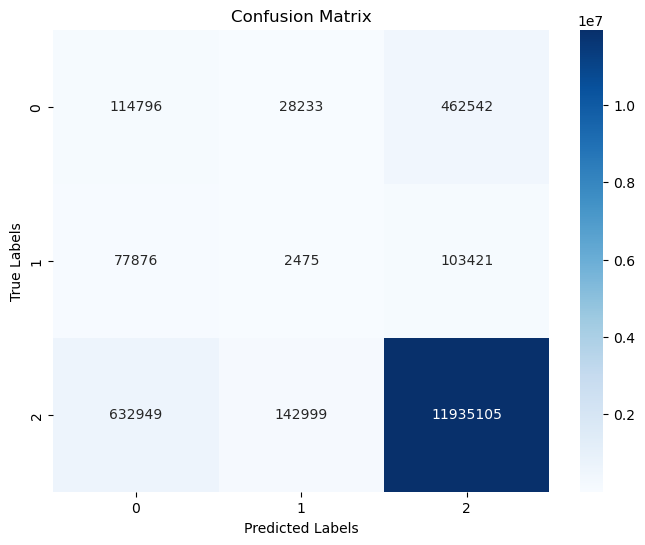

In [6]:
# create a confusion matrix
cm = confusion_matrix(Train_y_test, train_y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_des_tree.classes_,
            yticklabels=train_des_tree.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [7]:
# make predictions on the test data
test_y_pred = test_des_tree.predict(Test_X_test)

# calculate F1 score 
test_f1 = f1_score(Test_y_test, test_y_pred, average='weighted')
print(f"Test dataset F1 Score: {test_f1:.2f}")

Test dataset F1 Score: 0.90


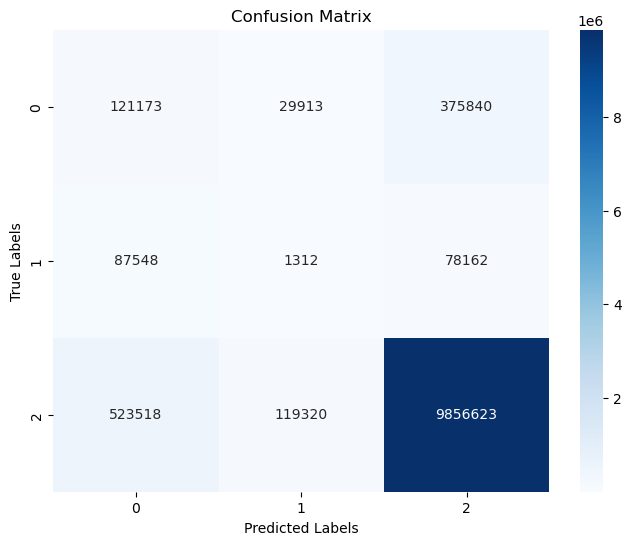

In [8]:
# create a confusion matrix
cm = confusion_matrix(Test_y_test, test_y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_des_tree.classes_,
            yticklabels=test_des_tree.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Results

Decision Tree shows an impressive 90% F1 score result which hits the target F1 score > 80%. It takes much less time to onboard the algorithm and start using it for prediction in comparison with deep learning training. However, the score is slightly worse than RNN results which might be sighnificat for use-cases that rely on more accurate prediction.

### Model Robustness

#### Retraining with K-fold

#### Testing the model on a different dataset

In [43]:
import pandas as pd
from tensorflow.keras.models import load_model

In [44]:
# Load the dataset, 55967041 rows
test_data = pd.read_csv('data/processed_data_test.csv')

In [155]:
# Load the model 
loaded_cnn_model = load_model('models/cnn_25.h5')  

In [138]:
# method for sequence generation 
def sequence_generator(X, y, sequence_length, batch_size):
    while True:
        for i in range(0, len(X) - sequence_length, batch_size):
            X_batch = [X[i+j:i+j+sequence_length] for j in range(batch_size)]
            y_batch = y[i:i+batch_size] 

            # Pad sequences to ensure they have the same length
            max_length = max(len(seq) for seq in X_batch)
            X_batch = [np.pad(seq, ((0, max_length - len(seq)), (0, 0)), 'constant') for seq in X_batch]

            X_batch = np.array(X_batch)
            y_batch = np.array(y_batch)

            yield X_batch, y_batch

In [147]:
td = test_data[0:10800000]

In [148]:
# Scale numerical features
scaler = StandardScaler()
# Combine all features
X = td[['event_time','product_id', 'category_id', 'cat', 'cat_2', 'cat_3', 'cat_4', 'brand', 'price']]
X = scaler.fit_transform(X)

# Convert target to categorical set
y = td['event_type']
y = to_categorical(y, num_classes=3)

In [149]:
# Create sequences from the data
sequence_length = 100 
batch_size = 150
test_data_generator = sequence_generator(X, y, sequence_length, batch_size)

In [156]:
loaded_cnn_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 9)]          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 98, 64)            1792      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 49, 64)            0         
 g1D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 3136)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               401536    
                                                                 
 dense_13 (Dense)            (None, 3)                 387       
                                                           

In [157]:
# Make predictions on the test data
y_pred = loaded_cnn_model.predict(test_data_generator, steps=len(X) // batch_size)
# Convert one-hot encoded predictions to class labels
y_pred = np.argmax(y_pred, axis=1)  

# Convert one-hot encoded true labels to class labels
y_true = np.argmax(y, axis=1)

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

72000/72000 [==============================] - 190s 3ms/step
F1 Score: 0.9196417026657279


## Conclusion